In [1]:
!pip install langgraph langchain langchain_openai tavily-python langchain_community "httpx==0.27.2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled

In [2]:
import os
os.environ["TAVILY_API_KEY"] = "tvly"
os.environ["OPENAI_API_KEY"] = "sk"

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolExecutor

tools = [TavilySearchResults(max_results=1)] # 도구 설정, 'max_results=1'은 검색 결과에서 최대 1개의 결과만 반환하도록 설정한다는 의미입니다
tool_executor = ToolExecutor(tools) # 도구를 실행할 수 있는 객체를 생성

<ipython-input-3-0ffd351f6ecc>:5: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools) # 도구를 실행할 수 있는 객체를 생성


In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True) # LLM 모델(ChatOpenAI)을 초기화, 'streaming=True'로 설정하면 모델의 출력이 한 번에 제공되지 않고 생성되는 즉시 스트리밍으로 반환합니다

In [5]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class AgentState(TypedDict): # 에이전트 상태 정의 (AgentState 클래스는 딕셔너리처럼 동작)
    messages: Annotated[list, add_messages]

In [6]:
from langgraph.prebuilt import ToolInvocation # 특정 도구를 호출하기 위해 필요한 정보(도구 이름과 입력값)를 캡슐화하는 LangGraph 클래스
import json
from langchain_core.messages import FunctionMessage # 도구 호출의 결과를 메시지 형식으로 표현

def should_continue(state): # 상태 검사
    messages = state['messages']
    last_message = messages[-1] # 메시지 히스토리에서 가장 최근 메시지를 가져옵니다
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    else:
        return "continue"

def call_model(state): # 모델 호출
    messages = state['messages']
    response = model.invoke(messages) # 모델에 메시지를 전달하고 응답을 생성
    return {"messages": [response]}

def call_tool(state): # 도구 호출
    messages = state['messages']
    last_message = messages[-1]
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(last_message.additional_kwargs["function_call"]["arguments"]),
    ) # 도구 호출 준비
    response = tool_executor.invoke(action) # 도구 실행
    function_message = FunctionMessage(content=str(response), name=action.tool) # 도구 실행 결과를 메시지로 캡슐화

    return {"messages": [function_message]}

In [7]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState) # 워크플로우 초기화
workflow.add_edge(START, "agent") # 워크플로우의 시작점(START)과 첫 번째 노드("agent")를 연결

workflow.add_node("agent", call_model) # call_model 함수(모델 호출) 실행하는 노드 추
workflow.add_node("tools", call_tool) # call_tool 함수(도구 호출) 실행하는 노드 추

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END
    }
) # 노드("agent")에서 'should_continue' 함수의 결과에 따라 다음 작업을 결정

workflow.add_edge('tools', 'agent') # 작업이 반복적으로 실행될 수 있도록 "action" 노드(call_tool)에서 "agent" 노드(call_model)로 다시 돌아갑니다.
graph = workflow.compile() # 정의된 워크플로우를 실행 가능한 형태로 컴파일합니다

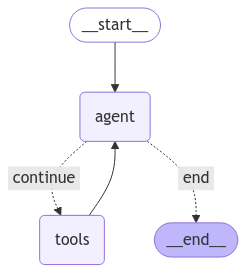

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png())) # 그래프로 시각화
except Exception: # 예외 처리
    pass

In [9]:
from langchain_core.messages import HumanMessage # HumanMessage: 사용자가 입력한 메시지를 나타내는 객체

inputs = {"messages": [HumanMessage(content="인간의 경제적 활동과 날씨의 관계는?")]} # 사용자 입력 데이터
graph.invoke(inputs) # 워크플로우 실행

{'messages': [HumanMessage(content='인간의 경제적 활동과 날씨의 관계는?', additional_kwargs={}, response_metadata={}, id='42db801b-8e58-4dd4-8fc4-b1b8be8f7af7'),
  AIMessage(content='인간의 경제적 활동과 날씨는 여러 가지 방식으로 상호작용합니다. 날씨는 다양한 산업과 경제 활동에 직접적 또는 간접적으로 영향을 미칠 수 있습니다. 다음은 그 관계의 몇 가지 예입니다:\n\n1. **농업**: 날씨는 농업에 가장 큰 영향을 미칩니다. 강수량, 온도, 일조량 등은 작물의 성장과 수확에 직접적인 영향을 미칩니다. 가뭄이나 홍수 같은 극단적인 날씨는 농작물의 생산량을 크게 감소시킬 수 있습니다.\n\n2. **에너지 소비**: 날씨는 에너지 수요에 영향을 미칩니다. 추운 날씨에는 난방 수요가 증가하고, 더운 날씨에는 냉방 수요가 증가합니다. 이는 전력 소비량에 직접적인 영향을 미치며, 에너지 가격 변동의 원인이 되기도 합니다.\n\n3. **건설업**: 날씨는 건설 프로젝트의 진행에 영향을 미칩니다. 비, 눈, 강풍 등은 건설 작업을 지연시킬 수 있으며, 이는 비용 증가로 이어질 수 있습니다.\n\n4. **소매업**: 날씨는 소비자 행동에도 영향을 미칩니다. 예를 들어, 추운 날씨에는 겨울 의류 판매가 증가하고, 더운 날씨에는 아이스크림이나 냉방 기기의 판매가 증가할 수 있습니다.\n\n5. **관광업**: 날씨는 관광 산업에도 큰 영향을 미칩니다. 좋은 날씨는 관광객을 유치하는 반면, 악천후는 관광객 수를 감소시킬 수 있습니다.\n\n6. **보험업**: 날씨 관련 재해는 보험 청구 건수를 증가시킬 수 있습니다. 홍수, 태풍, 폭설 등은 재산 피해를 유발하여 보험사의 손실로 이어질 수 있습니다.\n\n이처럼 날씨는 다양한 방식으로 경제 활동에 영향을 미치며, 기업과 정부는 이러한 영향을 최소화하기 위해 기상 데이터를 활용하여 전략을 수립하기도 합니다